# This noteboook is aimed at modelling returns of Bitcoin using traditional econometrics approach

## Importing libraries

In [1]:
# basic data-handling libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# libraries used in dataimports and modifications
from tvDatafeed import TvDatafeed, Interval
import pandas_ta as ta
import requests
import json
import datetime

In [3]:
# library for statistical analysis
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [4]:
# utilities
import sys
import nltk
sys.path.append('modules')
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kotakikuchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing data

In [5]:
bitcoin = utils.get_data('BTCUSDT', exchange = 'BINANCE',start_date = "2020-01-01")

you are using nologin method, data you access may be limited


In [6]:
#twitter = utils.processed_twitter_data()
# twitter_daily = twitter[['sentiment','created_at']].resample('D', on='created_at').mean()
# twitter_daily.index = twitter_daily.index.tz_localize(None)


In [13]:
twitter_daily = pd.read_pickle('../data/cleaned/by_date_verified_sentiments_2020-2021.pkl')

In [15]:
merged_df = bitcoin.merge(twitter_daily, how = 'outer', left_on = 'datetime', right_on = 'created_at')

In [16]:
merged_df.head()

,datetime,symbol,open,high,low,close,volume,created_at,weighted_sentiment
0,2020-01-01,BINANCE:BTCUSDT,7200.77,7212.50,6924.74,6965.71,31951.483932,2020-01-01,0.137061
1,2020-01-02,BINANCE:BTCUSDT,6965.49,7405.00,6871.04,7344.96,68428.500451,2020-01-02,0.080472
2,2020-01-03,BINANCE:BTCUSDT,7345.00,7404.00,7272.21,7354.11,29987.974977,2020-01-03,0.120766
3,2020-01-04,BINANCE:BTCUSDT,7354.19,7495.00,7318.00,7358.75,38331.085604,2020-01-04,0.062771
4,2020-01-05,BINANCE:BTCUSDT,7357.64,7795.34,7346.76,7758.00,54635.695316,2020-01-05,0.062458


### Linear Regression

Features - technical indicators.
Reference: https://www.alpharithms.com/predicting-stock-prices-with-linear-regression-214618/


In [10]:
'''
function to calculate technical indicators'''
def technical_indicator(df, column, technical_indicator, length):
    
    if technical_indicator == 'EMA':
        df.ta.ema(close = column, length = length, append = True, lookahead=False)
        
    return df
       
    

In [26]:
merged_df = technical_indicator(merged_df, 'close', 'EMA', length = 2)
merged_df = utils.lag_columns(merged_df, ['EMA_2'], +1)
merged_df = utils.lag_columns(merged_df, ['sentiment'], +1)

merged_df = utils.calculate_return(merged_df, ['close','EMA_2_1_days_lagged', 'sentiment_1_days_lagged'], 1)


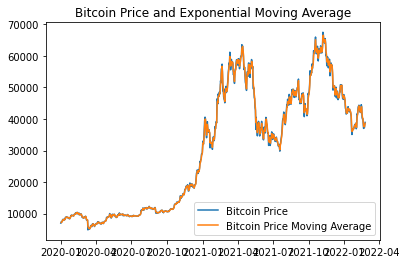

In [27]:
fig, ax = plt.subplots()

ax.plot(merged_df['datetime'],merged_df['close'], label = 'Bitcoin Price')
ax.plot(merged_df['datetime'],merged_df['EMA_2'], label = 'Bitcoin Price Moving Average')

plt.title("Bitcoin Price and Exponential Moving Average")
plt.legend()

# We need to lag the features to avoid leakage (lookahead bias). That is, you cannot use tomorrow's data to predict the price for tomorrow. We need to use what we know today to predict the price tomorrow.

In [28]:
merged_df.head()

,datetime,symbol,open,high,low,close,volume,sentiment,EMA_2,EMA_2_1_days_lagged,close_return,EMA_2_1_days_lagged_return,sentiment_1_days_lagged,sentiment_1_days_lagged_return
868,2020-01-01,BINANCE:BTCUSDT,7200.77,7212.50,6924.74,6965.71,31951.483932,0.174531,NaN,NaN,NaN,NaN,NaN,NaN
869,2020-01-02,BINANCE:BTCUSDT,6965.49,7405.00,6871.04,7344.96,68428.500451,0.136281,7155.335000,NaN,0.054445,NaN,0.174531,NaN
870,2020-01-03,BINANCE:BTCUSDT,7345.00,7404.00,7272.21,7354.11,29987.974977,0.173617,7287.851667,7155.335000,0.001246,NaN,0.136281,-0.219155
871,2020-01-04,BINANCE:BTCUSDT,7354.19,7495.00,7318.00,7358.75,38331.085604,0.127966,7335.117222,7287.851667,0.000631,0.018520,0.173617,0.273959
872,2020-01-05,BINANCE:BTCUSDT,7357.64,7795.34,7346.76,7758.00,54635.695316,0.101294,7617.039074,7335.117222,0.054255,0.006486,0.127966,-0.262939


<AxesSubplot:ylabel='Frequency'>

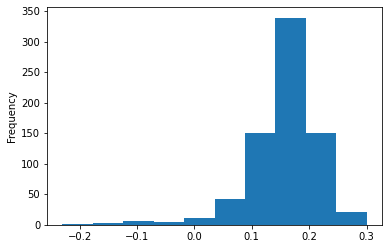

In [33]:
merged_df['sentiment'].plot(kind = 'hist')

In [20]:
formula_1 = 'close_return ~ EMA_2_1_days_lagged_return'
res_1 = ols(formula_1, data= merged_df).fit()

In [21]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:           close_return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.497
Date:                Fri, 25 Feb 2022   Prob (F-statistic):             0.0193
Time:                        17:33:35   Log-Likelihood:                 1403.5
No. Observations:                 783   AIC:                            -2803.
Df Residuals:                     781   BIC:                            -2794.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [29]:
formula_2 = 'close_return ~ EMA_2_1_days_lagged_return+sentiment_1_days_lagged_return '
res_2 = ols(formula_2, data= merged_df).fit()

In [30]:
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:           close_return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.746
Date:                Fri, 25 Feb 2022   Prob (F-statistic):             0.0648
Time:                        17:35:22   Log-Likelihood:                 1403.5
No. Observations:                 783   AIC:                            -2801.
Df Residuals:                     780   BIC:                            -2787.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   